In [28]:
import pandas as pd 
import numpy as np 
#import nltk 
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.naive_bayes import GaussianNB
from scipy import stats
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from mlxtend.preprocessing import OnehotTransactions
%matplotlib inline
import pickle
from itertools import combinations

In [2]:
# aisles
aisles = pd.read_csv('./data/aisles.csv')
aisles=aisles[aisles['aisle'] <> "missing"]
print('Total aisles: %i' %aisles.shape[0])
aisles.head()

Total aisles: 133


,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [4]:
# department
departments = pd.read_csv('./data/departments.csv')
departments = departments[departments['department'] <>"missing"]
print('Total departments: %i' %departments.shape[0])
print departments.head()

Total departments: 20
   department_id department
0              1     frozen
1              2      other
2              3     bakery
3              4    produce
4              5    alcohol


In [3]:
# orders
orders = pd.read_csv('./data/orders.csv')
orders_train = orders[orders['eval_set'] == 'train']
orders_prior = orders[orders['eval_set'] == 'prior']
orders_test = orders[orders['eval_set'] == 'test']
print orders_train.head()
print orders_test.head()
print orders_prior.head()

    order_id  user_id eval_set  order_number  order_dow  order_hour_of_day  \
10   1187899        1    train            11          4                  8   
25   1492625        2    train            15          1                 11   
49   2196797        5    train             5          0                 11   
74    525192        7    train            21          2                 11   
78    880375        8    train             4          1                 14   

    days_since_prior_order  
10                    14.0  
25                    30.0  
49                     6.0  
74                     6.0  
78                    10.0  
     order_id  user_id eval_set  order_number  order_dow  order_hour_of_day  \
38    2774568        3     test            13          5                 15   
44     329954        4     test             6          3                 12   
53    1528013        6     test             4          3                 16   
96    1376945       11     test          

In [6]:
# products
products = pd.read_csv('./data/products.csv')
print('Total products: %i' %products.shape[0])
products.head()

Total products: 49688


,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [4]:
# orders prior
prior_set = pd.read_csv('./data/order_products__prior.csv')
prior_set.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [5]:
# orders train
orders_train_set = pd.read_csv('./data/order_products__train.csv')
print orders_train_set.head()

   order_id  product_id  add_to_cart_order  reordered
0         1       49302                  1          1
1         1       11109                  2          1
2         1       10246                  3          0
3         1       49683                  4          0
4         1       43633                  5          1


# Merge products, aisle and department

In [10]:
items = pd.merge((pd.merge(products, aisles, on='aisle_id')), departments, on='department_id')
print items.head()
print items.shape
f = open('item.pckl', 'wb')
pickle.dump(items, f)
f.close()


   product_id                                    product_name  aisle_id  \
0           1                      Chocolate Sandwich Cookies        61   
1          78               Nutter Butter Cookie Bites Go-Pak        61   
2         102                           Danish Butter Cookies        61   
3         172  Gluten Free All Natural Chocolate Chip Cookies        61   
4         285                    Mini Nilla Wafers Munch Pack        61   

   department_id          aisle department  
0             19  cookies cakes     snacks  
1             19  cookies cakes     snacks  
2             19  cookies cakes     snacks  
3             19  cookies cakes     snacks  
4             19  cookies cakes     snacks  
(48430, 6)


In [6]:
f = open('item.pckl', 'rb')
items = pickle.load(f)
f.close()
print items.head()

   product_id                                    product_name  aisle_id  \
0           1                      Chocolate Sandwich Cookies        61   
1          78               Nutter Butter Cookie Bites Go-Pak        61   
2         102                           Danish Butter Cookies        61   
3         172  Gluten Free All Natural Chocolate Chip Cookies        61   
4         285                    Mini Nilla Wafers Munch Pack        61   

   department_id          aisle department  
0             19  cookies cakes     snacks  
1             19  cookies cakes     snacks  
2             19  cookies cakes     snacks  
3             19  cookies cakes     snacks  
4             19  cookies cakes     snacks  


# Merge products and prior orders

In [7]:
reorder_items = pd.merge(items, prior_set, on='product_id')
print reorder_items.head()
print reorder_items.shape

   product_id                product_name  aisle_id  department_id  \
0           1  Chocolate Sandwich Cookies        61             19   
1           1  Chocolate Sandwich Cookies        61             19   
2           1  Chocolate Sandwich Cookies        61             19   
3           1  Chocolate Sandwich Cookies        61             19   
4           1  Chocolate Sandwich Cookies        61             19   

           aisle department  order_id  add_to_cart_order  reordered  
0  cookies cakes     snacks      1107                  7          0  
1  cookies cakes     snacks      5319                  3          1  
2  cookies cakes     snacks      7540                  4          1  
3  cookies cakes     snacks      9228                  2          0  
4  cookies cakes     snacks      9273                 30          0  
(32365344, 9)


In [ ]:
reorder_items1 = pd.merge(reorder_items, orders_prior, on='order_id')
print reorder_items1.head()
print reorder_items1.shape

   product_id                   product_name  aisle_id  department_id  \
0           1     Chocolate Sandwich Cookies        61             19   
1       46149              Zero Calorie Cola        77              7   
2        9434            Bag of Large Lemons        34              1   
3         769         Sliced American Cheese        21             16   
4       12078  Shredded Mexican Blend Cheese        21             16   

                 aisle  department  order_id  add_to_cart_order  reordered  \
0        cookies cakes      snacks      1107                  7          0   
1          soft drinks   beverages      1107                  6          0   
2  frozen meat seafood      frozen      1107                  2          0   
3      packaged cheese  dairy eggs      1107                 10          0   
4      packaged cheese  dairy eggs      1107                  9          0   

   user_id eval_set  order_number  order_dow  order_hour_of_day  \
0    38259    prior      

# Merge items and order trains

In [17]:
order_train_items = pd.merge(items, orders_train_set, on='product_id')
print order_train_items.head()
print order_train_items.shape

   product_id                product_name  aisle_id  department_id  \
0           1  Chocolate Sandwich Cookies        61             19   
1           1  Chocolate Sandwich Cookies        61             19   
2           1  Chocolate Sandwich Cookies        61             19   
3           1  Chocolate Sandwich Cookies        61             19   
4           1  Chocolate Sandwich Cookies        61             19   

           aisle department  order_id  add_to_cart_order  reordered  
0  cookies cakes     snacks      6695                  7          1  
1  cookies cakes     snacks     48361                  9          0  
2  cookies cakes     snacks     63770                  4          0  
3  cookies cakes     snacks     75339                  9          0  
4  cookies cakes     snacks    240996                  3          1  
(1376366, 9)


In [18]:
order_train_items1 = pd.merge(order_train_items, orders_train, on='order_id')
print order_train_items1.head()
print order_train_items1.shape

   product_id                product_name  aisle_id  department_id  \
0           1  Chocolate Sandwich Cookies        61             19   
1       40199      Chocolate Chip Cookies        61             19   
2       45051                     Pub Mix       107             19   
3       10310        Wheat Thins Original        78             19   
4       37600         Organic Kettle Corn        23             19   

            aisle department  order_id  add_to_cart_order  reordered  user_id  \
0   cookies cakes     snacks      6695                  7          1     1540   
1   cookies cakes     snacks      6695                 17          1     1540   
2  chips pretzels     snacks      6695                  6          1     1540   
3        crackers     snacks      6695                 20          1     1540   
4   popcorn jerky     snacks      6695                  1          1     1540   

  eval_set  order_number  order_dow  order_hour_of_day  days_since_prior_order  
0    train 

In [16]:
f = open('order_train_items1.pckl', 'wb')
pickle.dump(order_train_items1, f)
f.close()

In [ ]:
f = open('order_train_items1.pckl', 'rb')
order_train_items1 = pickle.load(f)
f.close()
print order_train_items1.head()

# Group by department - count products in each department

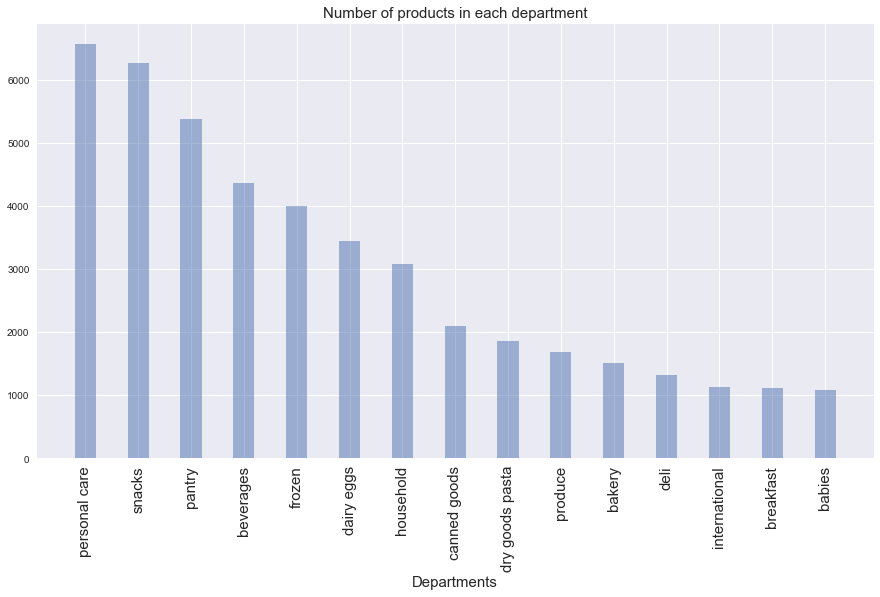

In [33]:
#count is a series. Hence index and values are used to access data
plt.figure(figsize=(15, 8))
count_prod = items.groupby(['department']).count()['product_id'].sort_values(ascending=False)[:15] 
plt.bar(np.arange(len(count_prod)), count_prod.values, width=0.4, alpha =0.5)
plt.xticks(np.arange(len(count_prod)), count_prod.index, rotation=90, size=15)
plt.title("Number of products in each department", size=15)
plt.xlabel("Departments", size=15)

# Group by aisle - count products in each aisle

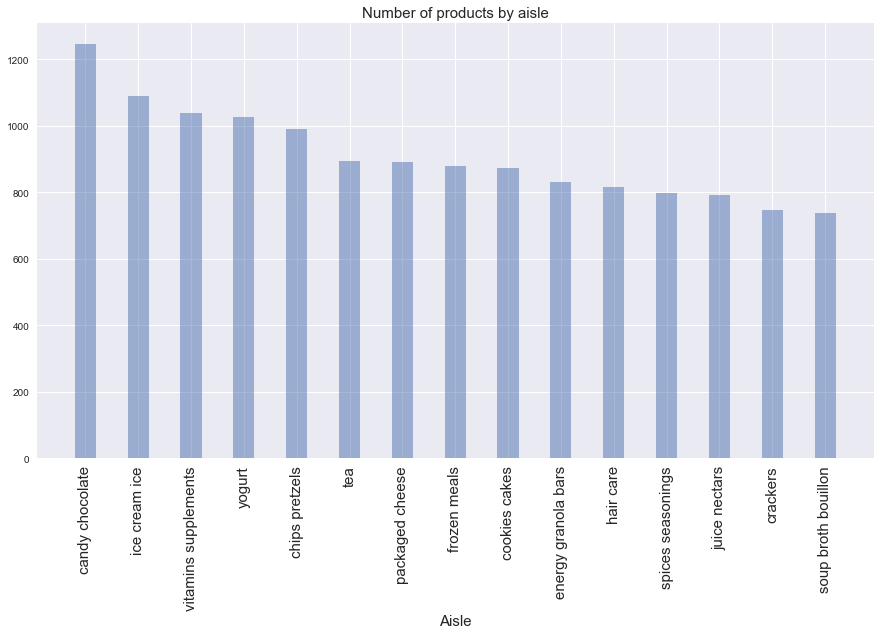

In [34]:
plt.figure(figsize=(15, 8))
count_ais_dep = items.groupby(['aisle']).count()['product_id'].sort_values(ascending=False)[:15]
plt.bar(np.arange(len(count_ais_dep)), count_ais_dep.values, width=0.4, alpha =0.5)
plt.xticks(np.arange(len(count_ais_dep)), count_ais_dep.index, rotation=90, size=15)
plt.xlabel("Aisle", size=15)
plt.title("Number of products by aisle", size=15)


# Count products in each aisle under each department

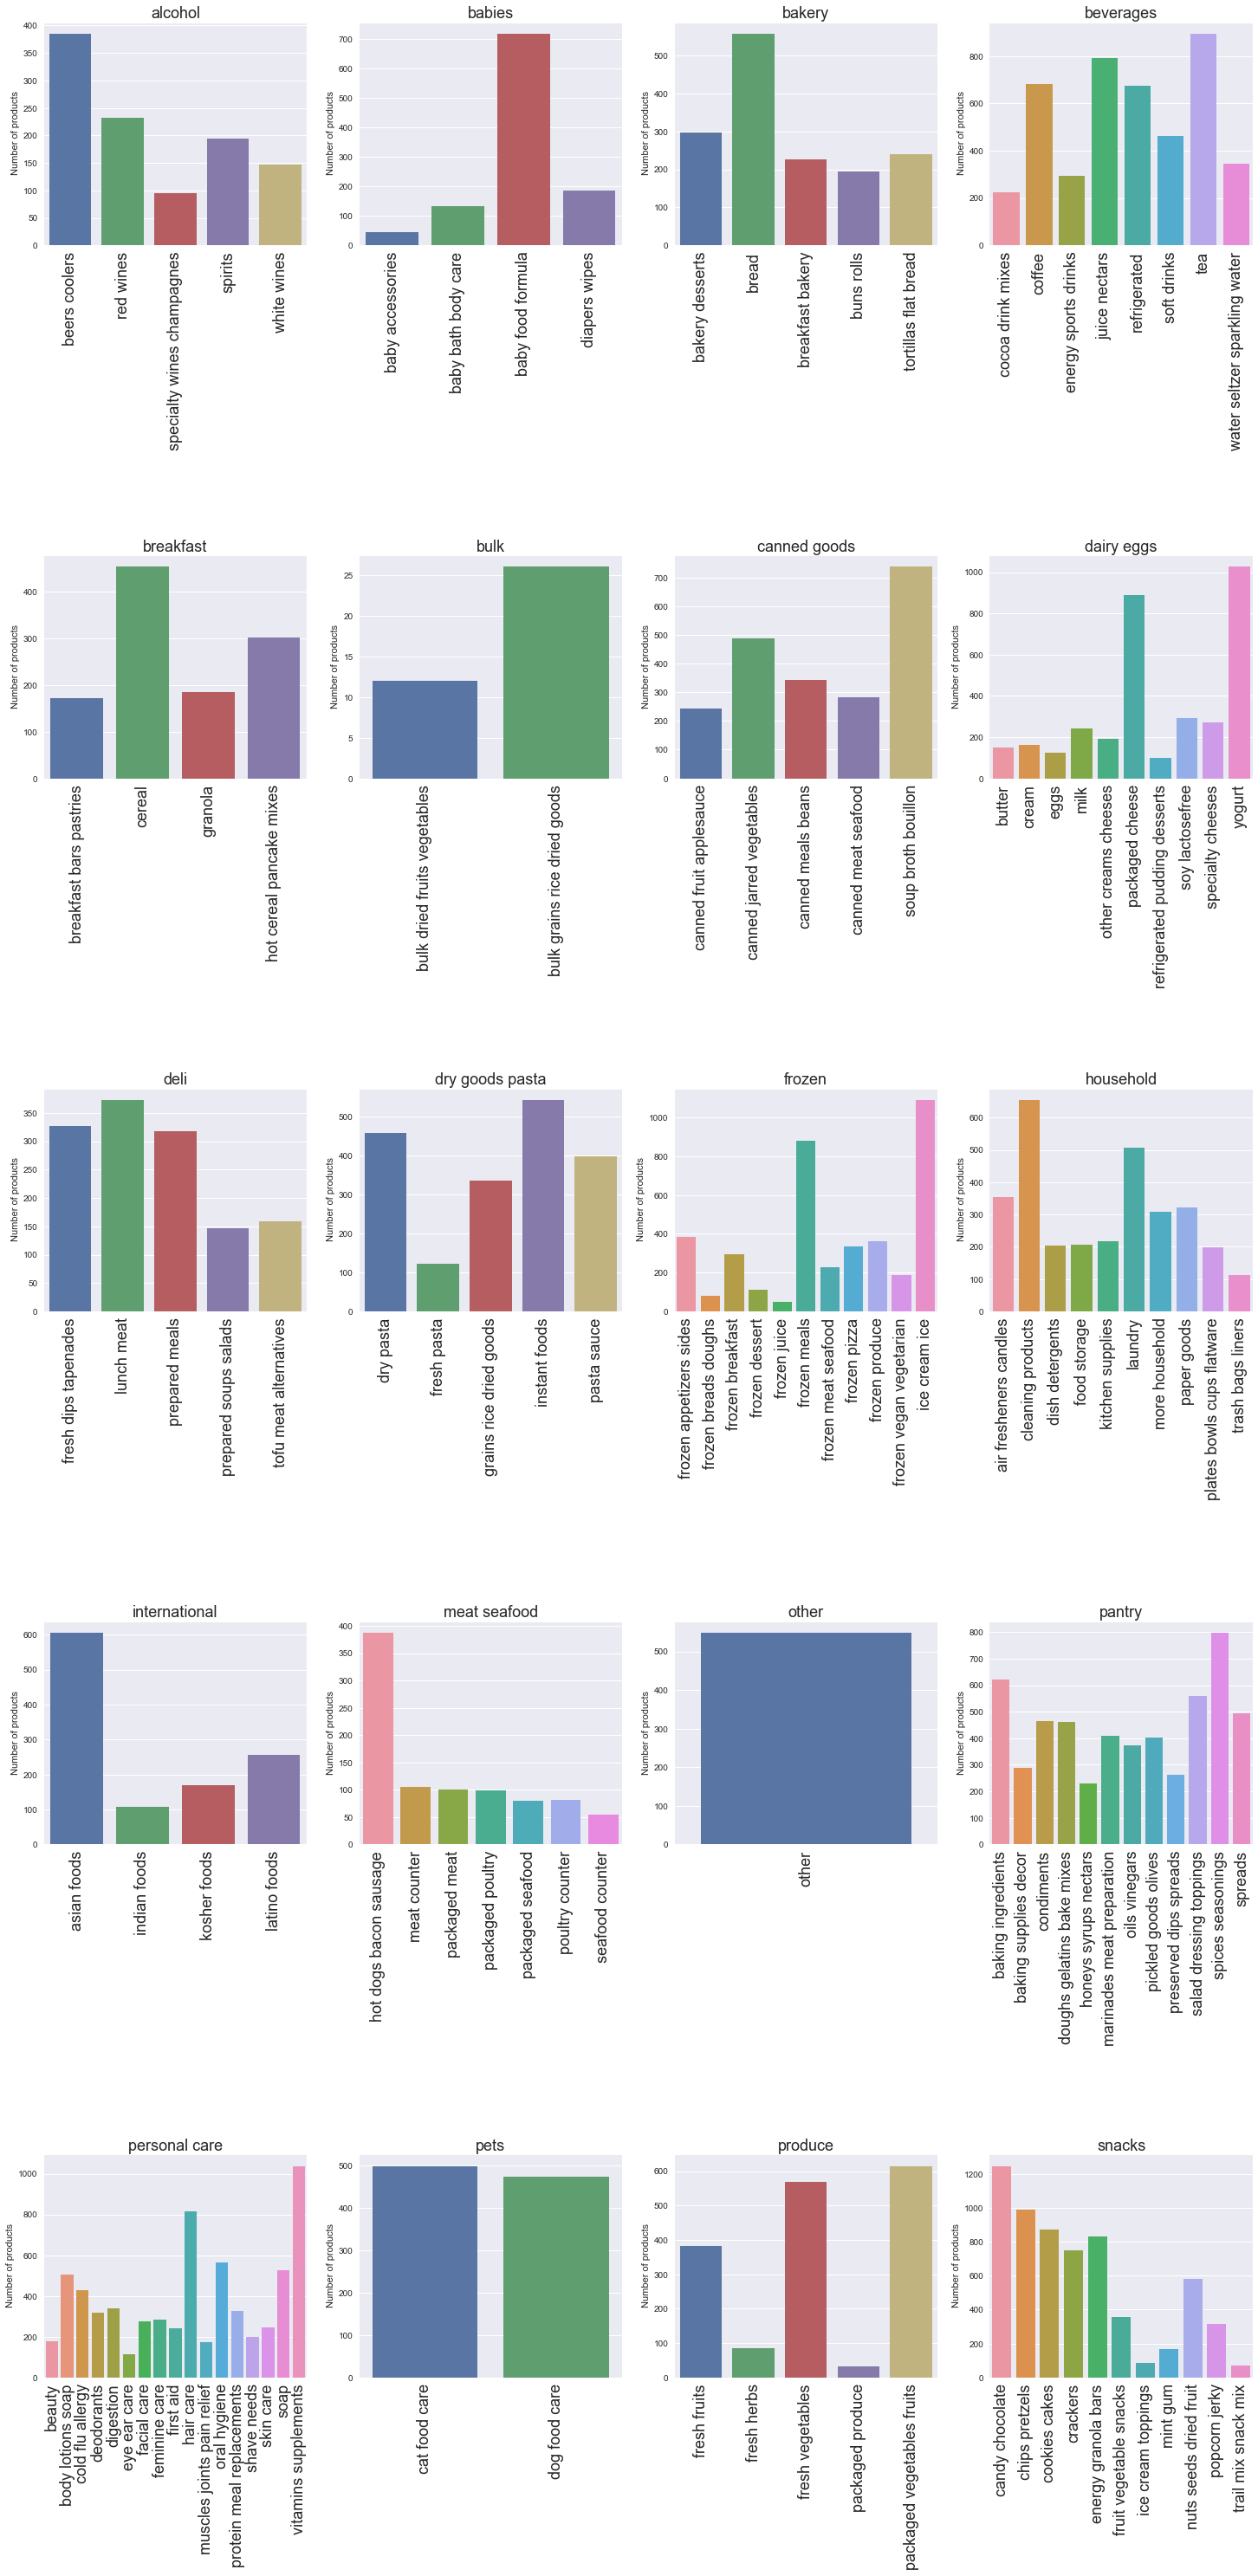

In [35]:
group_prod = pd.DataFrame(items.groupby(['department', 'aisle']).count()["product_id"]).reset_index()
group_prod.columns = ['Department', 'Aisle', 'Count']

fig, axis = plt.subplots(5, 4, figsize=(25,50), gridspec_kw=dict(hspace=1.4))
for (dept, aisle), axis in zip(group_prod.groupby(["Department"]), axis.flatten()):
      g=sns.barplot(aisle.Aisle, aisle.Count, ax=axis)
      axis.set(xlabel = " ", ylabel=" Number of products")
      g.set_xticklabels(labels = aisle.Aisle,rotation=90, fontsize=18)
      axis.set_title(dept, fontsize=18)

# Reorders in orders_train and orders_prior

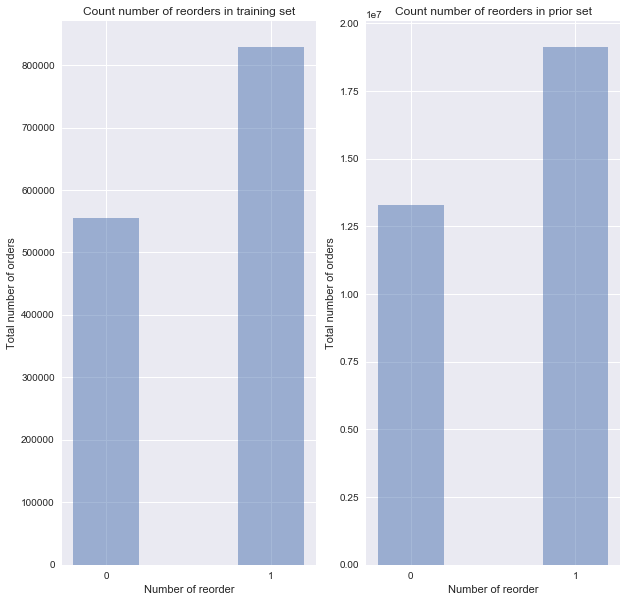

In [77]:
fig, axis = plt.subplots(1, 2, figsize=(10,10))
train_reorder = orders_train_set.groupby('reordered').count()['order_id'] 
prior_reorder = prior_set.groupby('reordered').count()['order_id']
plt.setp(axis, xticks=np.arange(len(train_reorder)) \
        , xlabel = "Number of reorder" \
        , ylabel = "Total number of orders" )
             
axis[0].bar(np.arange(len(train_reorder)), train_reorder.values, width=0.4, alpha =0.5)
axis[0].set_title('Count number of reorders in training set')
axis[1].bar(np.arange(len(prior_reorder)), prior_reorder.values, width=0.4, alpha =0.5)
 
plt.xticks(np.arange(len(prior_reorder)),  size=10)
plt.title('Count number of reorders in prior set')


# Reorders each day of the week - prior and training set

In [17]:
train_reorder_dow = order_train_items1[order_train_items1['reordered'] >= 1].groupby(['order_dow']).count()['order_id']

In [ ]:
reorder_dow = reorder_items1[reorder_items1['reordered'] >= 1]

In [21]:
reorder_dow = reorder_dow.groupby(['order_dow']).count()['order_id']

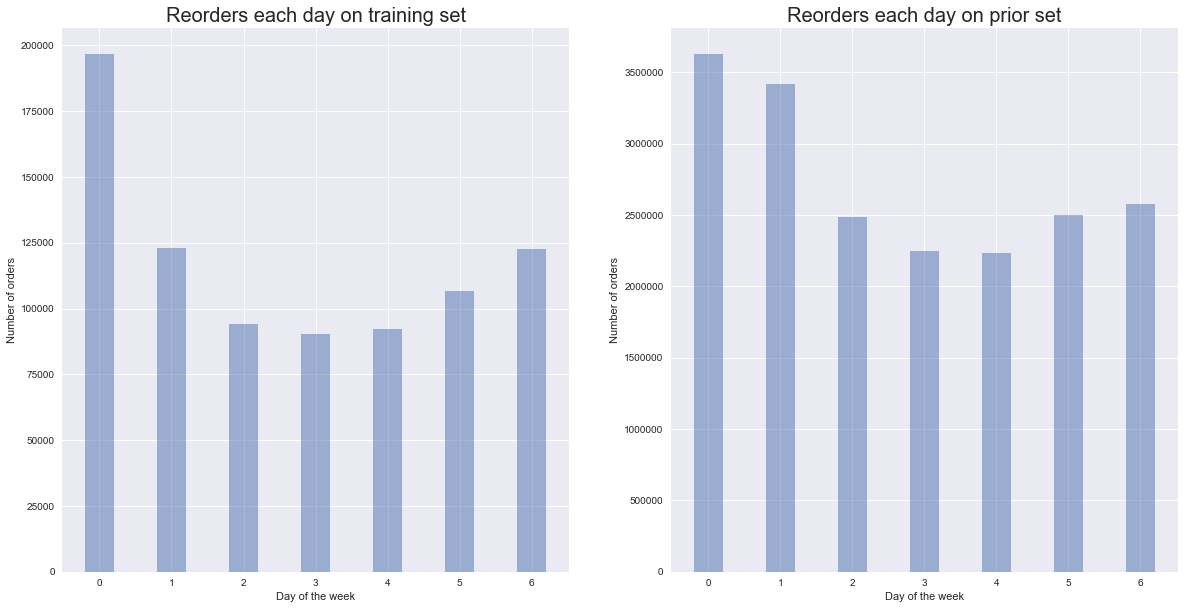

In [29]:
fig, axis = plt.subplots(1, 2, figsize=(20,10))
plt.setp(axis, xlabel = "Day of the week" \
        , ylabel = "Number of orders" )
             
axis[1].bar(np.arange(len(reorder_dow)), reorder_dow.values, width=0.4, alpha=0.5)
axis[0].bar(np.arange(len(train_reorder_dow)), train_reorder_dow.values, width=0.4, alpha=0.5)
axis[0].set_title('Reorders each day on training set', size=20)
axis[1].set_title('Reorders each day on prior set', size=20)


In [ ]:
#popular products fror reorder

In [74]:
train_reorder_prod = order_train_items1[order_train_items1['reordered'] >= 1].groupby(['product_name']).count()['product_id']
train_reorder_prod = train_reorder_prod .sort_values(ascending=False)

In [127]:
print train_reorder_prod.head()

product_name
Banana                    16557
Bag of Organic Bananas    13362
Organic Strawberries       8603
Organic Baby Spinach       8055
Organic Avocado            6226
Name: product_id, dtype: int64


In [75]:
prior_reorder_prod = reorder_items1[reorder_items1['reordered'] >= 1]
prior_reorder_prod = prior_reorder_prod.groupby(['product_name']).count()['product_id']
prior_reorder_prod = prior_reorder_prod .sort_values(ascending=False)
print prior_reorder_prod.head()

product_name
Banana                    398609
Bag of Organic Bananas    315913
Organic Strawberries      205845
Organic Baby Spinach      186884
Organic Hass Avocado      170131
Name: product_id, dtype: int64


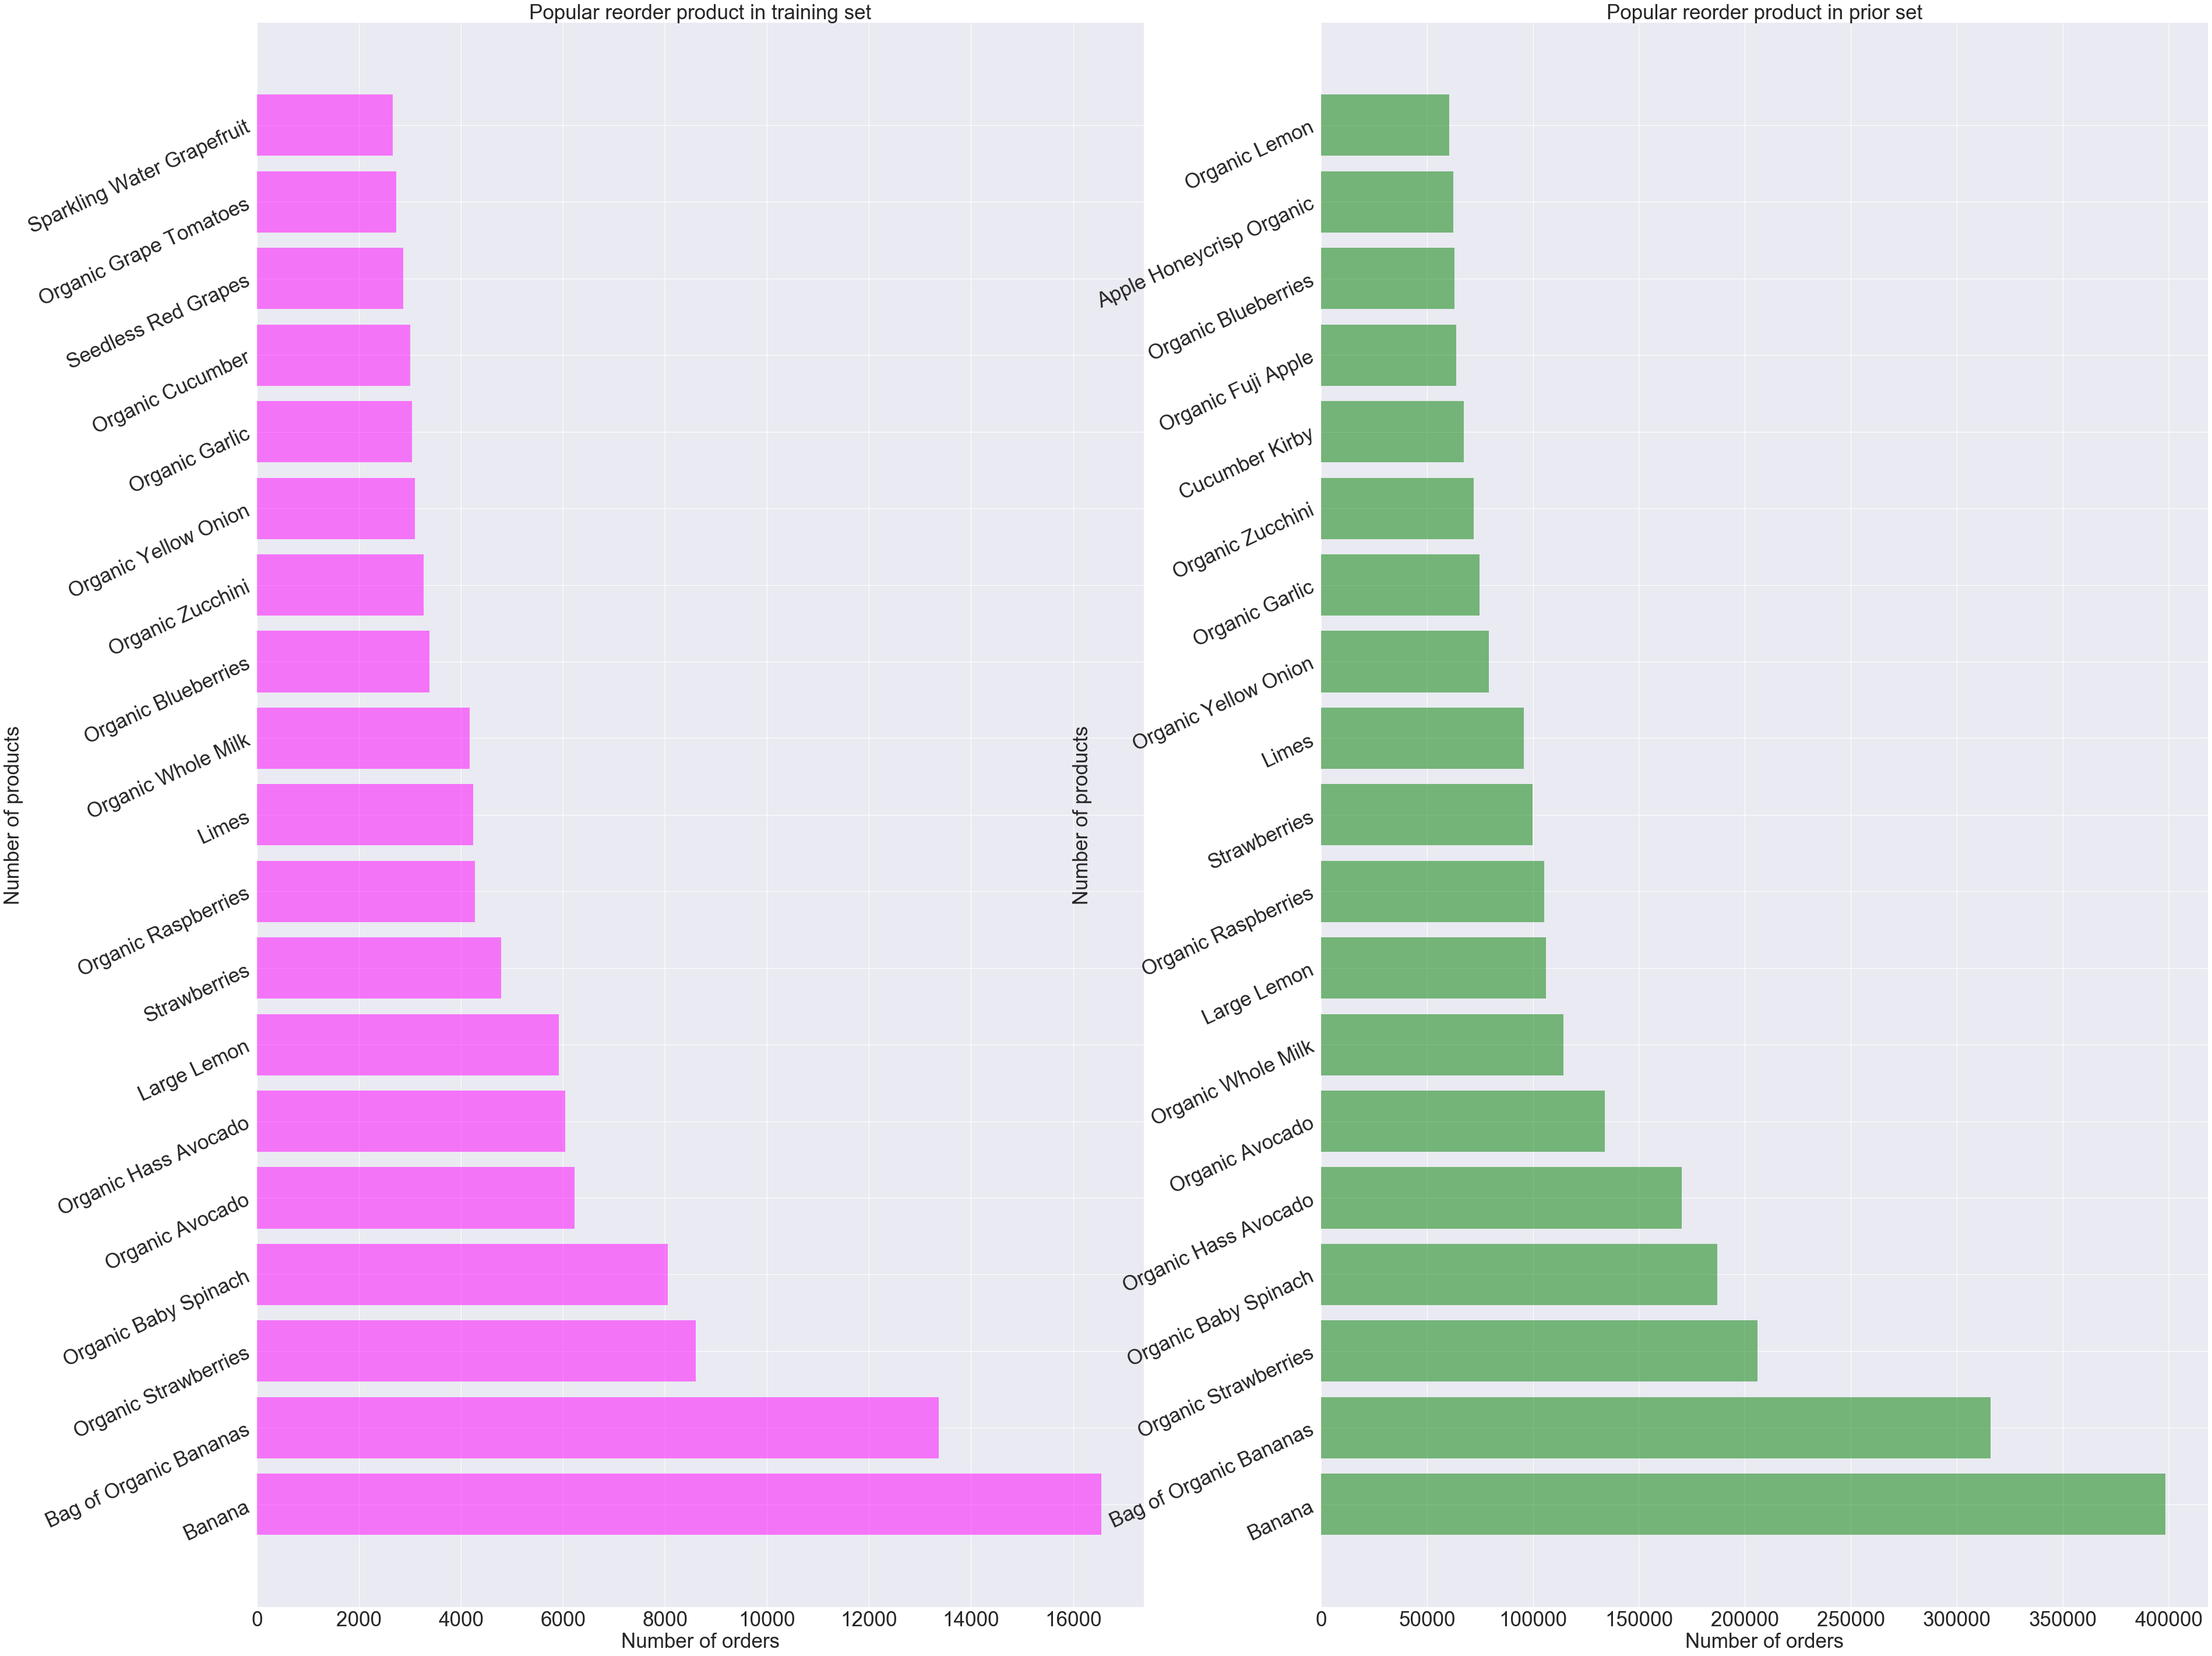

In [138]:
fig, axis = plt.subplots(1, 2, figsize=(60,50))
             
bar1 = np.arange(len(train_reorder_prod[0:19].index))
bar2=np.arange(len(prior_reorder_prod[0:19].index))
axis[0].barh(bar1, train_reorder_prod.values[0:19], align='center', alpha=0.5, \
             color='magenta')
axis[0].set_title('Popular reorder product in training set', size=35)
axis[0].set_yticklabels(train_reorder_prod[0:19].index, size=30, rotation=25)
axis[0].set_yticks(bar1)
axis[0].tick_params(labelsize=35)
axis[0].set_xlabel("Number of orders" , size=35)
axis[0].set_ylabel("Number of products", size=35)

axis[1].barh(bar2, prior_reorder_prod.values[0:19], align='center', alpha=0.5, color='green')
axis[1].set_title('Popular reorder product in prior set', size=35)
axis[1].set_yticklabels(prior_reorder_prod[0:19].index, size=30, rotation=25)
axis[1].tick_params(labelsize=35)
axis[1].set_yticks(bar2)
axis[1].set_xlabel("Number of orders" , size=35)
axis[1].set_ylabel("Number of products" , size=35)




### Association rule

In [56]:
prior_cart_order = reorder_items1[prior_cart_order['reordered'] >=1]

In [12]:
    prior_cart_order =  prior_cart_order[1:300000]

In [13]:
prior_cart_order['product_name'] = prior_cart_order['product_name'].str.strip()
prior_cart_order['order_id'] = prior_cart_order['order_id'].astype('str')

In [14]:
prior_cart_order = prior_cart_order.groupby(['order_id', 'product_name'])['add_to_cart_order']  \
                .sum().unstack().reset_index().fillna(0).set_index('order_id')

In [15]:
print prior_cart_order.head()
print prior_cart_order.shape

product_name  #2 Coffee Filters  #4 Natural Brown Coffee Filters  \
order_id                                                           
1000035                     0.0                              0.0   
1000112                     0.0                              0.0   
1000134                     0.0                              0.0   
1000163                     0.0                              0.0   
1000304                     0.0                              0.0   

product_name  & Go! Hazelnut Spread + Pretzel Sticks  \
order_id                                               
1000035                                          0.0   
1000112                                          0.0   
1000134                                          0.0   
1000163                                          0.0   
1000304                                          0.0   

product_name  0 Calorie Acai Raspberry Water Beverage  \
order_id                                                
1000035         

In [16]:
def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return x

basket_sets = prior_cart_order.applymap(encode_units)
print basket_sets


product_name  #2 Coffee Filters  #4 Natural Brown Coffee Filters  \
order_id                                                           
1000035                     0.0                              0.0   
1000112                     0.0                              0.0   
1000134                     0.0                              0.0   
1000163                     0.0                              0.0   
1000304                     0.0                              0.0   
1000368                     0.0                              0.0   
1000726                     0.0                              0.0   
1000770                     0.0                              0.0   
1001068                     0.0                              0.0   
1001131                     0.0                              0.0   
1001451                     0.0                              0.0   
1001467                     0.0                              0.0   
1001535                     0.0                 

In [176]:
print basket_sets.columns
print basket_sets.head()

Index([u'#2 Coffee Filters', u'#4 Natural Brown Coffee Filters',
       u'& Go! Hazelnut Spread + Pretzel Sticks',
       u'0 Calorie Acai Raspberry Water Beverage',
       u'0 Calorie Strawberry Dragonfruit Water Beverage',
       u'0% Fat Black Cherry Greek Yogurt y', u'0% Fat Blueberry Greek Yogurt',
       u'0% Fat Free Organic Milk', u'0% Fat Organic Greek Vanilla Yogurt',
       u'0% Fat Peach Greek Yogurt',
       ...
       u'gel hand wash sea minerals', u'in 100% Juice Mixed Fruit',
       u'of Hanover 100 Calorie Pretzels Mini',
       u'smartwater® Electrolyte Enhanced Water',
       u'vitaminwater® XXX Acai Blueberry Pomegranate',
       u'with Crispy Almonds Cereal', u'with Olive Oil Mayonnaise Dressing',
       u'with Seasoned Roasted Potatoes Scrambled Eggs & Sausage',
       u'with Xylitol Cinnamon 18 Sticks Sugar Free Gum',
       u'with Xylitol Watermelon Twist 18 Sticks Sugar Free Gum'],
      dtype='object', name=u'product_name', length=19615)
product_name  #2 Coffe

In [180]:

basket = basket_sets.iloc[2:,:]
basket.head()

product_name,#2 Coffee Filters,#4 Natural Brown Coffee Filters,& Go! Hazelnut Spread + Pretzel Sticks,0 Calorie Acai Raspberry Water Beverage,0 Calorie Strawberry Dragonfruit Water Beverage,0% Fat Black Cherry Greek Yogurt y,0% Fat Blueberry Greek Yogurt,0% Fat Free Organic Milk,0% Fat Organic Greek Vanilla Yogurt,0% Fat Peach Greek Yogurt,...,gel hand wash sea minerals,in 100% Juice Mixed Fruit,of Hanover 100 Calorie Pretzels Mini,smartwater® Electrolyte Enhanced Water,vitaminwater® XXX Acai Blueberry Pomegranate,with Crispy Almonds Cereal,with Olive Oil Mayonnaise Dressing,with Seasoned Roasted Potatoes Scrambled Eggs & Sausage,with Xylitol Cinnamon 18 Sticks Sugar Free Gum,with Xylitol Watermelon Twist 18 Sticks Sugar Free Gum
order_id,,,,,,,,,,,,,,,,,,,,,
1000134,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000163,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000304,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000368,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000726,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
frequent_itemsets = apriori(basket_sets, min_support=0.5, use_colnames=True)
 

      support                                           itemsets
0    0.106786                     [100 Calorie  Per Bag Popcorn]
1    0.097220                           [100% Raw Coconut Water]
2    0.086337                       [100% Recycled Paper Towels]
3    0.175343                           [100% Whole Wheat Bread]
4    0.133578                              [2% Reduced Fat Milk]
5    0.061625  [Aged White Cheddar Baked Rice & Corn Puffs Gl...
6    0.052405                       [All Natural Marinara Sauce]
7    0.055733             [Almonds & Sea Salt in Dark Chocolate]
8    0.192673                         [Apple Honeycrisp Organic]
9    0.163386                                        [Asparagus]
10   0.078573                   [Backyard Barbeque Potato Chips]
11   0.715444                           [Bag of Organic Bananas]
12   0.082421     [Baked Aged White Cheddar Rice and Corn Puffs]
13   0.053965    [Baked Rice and Corn Puffs, Aged White Cheddar]
14   0.976986            

In [181]:
frequent_itemsets

,support,itemsets
0,0.106786,[100 Calorie Per Bag Popcorn]
1,0.097220,[100% Raw Coconut Water]
2,0.086337,[100% Recycled Paper Towels]
3,0.175343,[100% Whole Wheat Bread]
4,0.133578,[2% Reduced Fat Milk]
5,0.061625,[Aged White Cheddar Baked Rice & Corn Puffs Gl...
6,0.052405,[All Natural Marinara Sauce]
7,0.055733,[Almonds & Sea Salt in Dark Chocolate]
8,0.192673,[Apple Honeycrisp Organic]
9,0.163386,[Asparagus]


In [168]:
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.9)
print rules


Empty DataFrame
Columns: []
Index: []


In [150]:
reorder_cart_order = order_train_items1[order_train_items1['reordered'] >=1]

In [151]:
reorder_cart_order.loc[:,'product_name'] = reorder_cart_order['product_name'].str.strip()
reorder_cart_order.loc[:,'order_id'] = reorder_cart_order['order_id'].astype('str')

In [152]:
reorder_basket_sets = reorder_cart_order.applymap(encode_units)
print reorder_basket_sets.head()

   product_id                product_name  aisle_id  department_id  \
0           1  Chocolate Sandwich Cookies        61             19   
1       40199      Chocolate Chip Cookies        61             19   
2       45051                     Pub Mix       107             19   
3       10310        Wheat Thins Original        78             19   
4       37600         Organic Kettle Corn        23             19   

            aisle department order_id  add_to_cart_order  reordered  user_id  \
0   cookies cakes     snacks     6695                  7          1     1540   
1   cookies cakes     snacks     6695                 17          1     1540   
2  chips pretzels     snacks     6695                  6          1     1540   
3        crackers     snacks     6695                 20          1     1540   
4   popcorn jerky     snacks     6695                  1          1     1540   

  eval_set  order_number  order_dow  order_hour_of_day  days_since_prior_order  
0    train       

In [160]:
reorder_cart_order = reorder_basket_sets.groupby(['order_id', 'product_name'])['add_to_cart_order'].fillna(0)
#.sum().unstack().reset_index().fillna(0).set_index('order_id')

In [145]:
reorder_cart_order = reorder_cart_order.sum()

In [161]:
frequent_itemsets_train = apriori(reorder_cart_order, min_support=0.05, use_colnames=True)
print frequent_itemsets_train

IndexError: tuple index out of range

# Max orders of customers

# Frequency of order by week

In [ ]:
#Best selling product

In [ ]:
Frequency of order by time

In [ ]:
Frequency of reorders

In [ ]:
Number of orders in training and test and prior dataset

In [169]:
dataset = [['Milk', 'Onion', 'Nutmeg', 'Kidney Beans', 'Eggs', 'Yogurt'], ['Dill', 'Onion', 'Nutmeg', 'Kidney Beans', 'Eggs', 'Yogurt'], ['Milk', 'Apple', 'Kidney Beans', 'Eggs'], ['Milk', 'Unicorn', 'Corn', 'Kidney Beans', 'Yogurt'], ['Corn', 'Onion', 'Onion', 'Kidney Beans', 'Ice cream', 'Eggs']]
oht = OnehotTransactions() 
oht_ary = oht.fit(dataset).transform(dataset) 
df = pd.DataFrame(oht_ary, columns=oht.columns_)  
print df

   Apple  Corn  Dill  Eggs  Ice cream  Kidney Beans  Milk  Nutmeg  Onion  \
0      0     0     0     1          0             1     1       1      1   
1      0     0     1     1          0             1     0       1      1   
2      1     0     0     1          0             1     1       0      0   
3      0     1     0     0          0             1     1       0      0   
4      0     1     0     1          1             1     0       0      1   

   Unicorn  Yogurt  
0        0       1  
1        0       1  
2        0       0  
3        1       1  
4        0       0  
